In [1]:
# input 이미지를 5분할하는 함수
def image_crop(file, image_width, image_height, cropped_width, cropped_height):
    cropped_images = []
    x = 0
    x_center = image_width // 2
    y_center = image_height // 2
    
    while x < image_width:
        y = 0
        while y < image_height:
            cropped_image = file[x : x + cropped_width, y : y + cropped_height]
            cropped_images.append(cropped_image)
            y += cropped_height
        x += cropped_width
    
    center_image = file[x_center - cropped_width // 2 : x_center + cropped_width // 2,
                       y_center - cropped_height // 2 : y_center + cropped_height // 2]
    
    cropped_images.append(center_image)
    
    return cropped_images

In [2]:
# 이미지를 조작하고 다룰 수 있게 처리해주는 함수
def data_generator(file, image_width, image_height):
    img_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (image_width, image_height))

    return img

In [3]:
import cv2
import os, glob, numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

img_dir = './binary_cnn_majority/test'
categories = ['ad', 'non_ad']

image_width = 220 # 사이즈 수정
image_height = 220

X = [] # 5분할 한 input 이미지
y = [] # input의 실제 분류 값 * 5
X_original = [] # input 이미지
y_original = [] # input의 실제 분류 값
index = []
files = []
filenames = []

n = 1
df = pd.DataFrame(index=['img_num'], columns=['y', 'pred', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'category'])
# y는 실제 분류 값, pred는 모델이 예측한 값

for i, category in enumerate(categories):
    img_detail = img_dir + '/' + category

    files.append(glob.glob(img_detail + "/*.jpg"))
    index.append(i)

In [4]:
for file, i in zip(files, index):
    for f in file:
        try:
            img = data_generator(f, image_width, image_height)
        
            original_data = np.asarray(img)
            X_original.append(original_data)
            y_original.append(i)

            df.loc[n, 'y'] = i
            n += 1

            cropped_images = image_crop(img, image_width, image_height, image_width // 2, image_height // 2)

            for cropped_image in cropped_images:
                data = np.asarray(cropped_image)

                head, tail = os.path.split(f)
                filenames.append(tail)

                X.append(data)
                y.append(i)
                
        except Exception as e:
            print(i,'번째에서 에러')

X = np.array(X)
y = np.array(y)
X_original = np.array(X_original)
y_original = np.array(y_original)

In [5]:
X = X.astype('float32') / 255

print(len(X), len(y))
print(len(X_original), len(y_original))

"""인자 바꾸기"""

print(df)

3480 3480
696 696
           y pred  X_0  X_1  X_2  X_3  X_4 category
img_num  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN
1          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
2          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
3          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
4          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
...      ...  ...  ...  ...  ...  ...  ...      ...
692        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
693        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
694        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
695        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
696        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN

[697 rows x 8 columns]


In [6]:
def print_scores(X, y, prediction):
    print('confusion matrix 결과')
    print(confusion_matrix(y, prediction, labels=[0, 1])) # 0: 광고, 1: 비광고

    print('precision 개별값')
    print(list(map('{:2.2f}%'.format, precision_score(y, prediction, average=None) * 100))) # precision 개별 값
    print('recall 개별값')
    print(list(map('{:2.2f}%'.format, recall_score(y, prediction, average=None) * 100)))

    
    print('f1 점수')
    print('{:2.2f}%'.format(f1_score(y, prediction, average='macro') * 100))

    print('precision 평균값')
    print('{:2.2f}%'.format(precision_score(y, prediction, average='macro') * 100)) # precision 평균 값
    
    print('recall 평균값')
    print('{:2.2f}%'.format(recall_score(y, prediction, average='macro') * 100))

In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


model_evaluate = []
f1 = []
precision = []
recall = []


model = load_model('./binary_cnn_majority/model/size/binary_model_saved_iv40.h5') # 모델 경로 수정

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # 소수점 3자리까지 표기

prediction_original = []    
count = []

n = 1

# print(prediction)
# print(prediction.shape)

In [8]:
for p in prediction:
    is_ad = 0
    not_ad = 0
    amax = []

    count.append(p)
    
    if(len(count) == 1):
        df.loc[n, 'X_0'] = p
        continue

    elif(len(count) == 2):
        df.loc[n, 'X_1'] = p
        continue
        
    elif(len(count) == 3):
        df.loc[n, 'X_2'] = p
        continue    
        
    elif(len(count) == 4):
        df.loc[n, 'X_3'] = p
        continue
        
    elif len(count) == 5:
        df.loc[n, 'X_4'] = p
        
        for c in count:
            amax.append(c.round())
            if c.round() == 0:
                is_ad += 1
            elif c.round() == 1:
                not_ad += 1

        if is_ad > not_ad:
            prediction_original.append(0)
    
            df.loc[n, 'pred'] = 0
            n += 1
            
        else:
            prediction_original.append(1)
            
            df.loc[n, 'pred'] = 1
            n += 1

        count = []


print('투표 결과')
print(len(y_original), len(prediction_original))
print_scores(X_original, y_original, prediction_original)
precision.append(precision_score(y_original, prediction_original, average='macro') * 100)
recall.append(recall_score(y_original, prediction_original, average='macro') * 100)
f1.append(f1_score(y_original, prediction_original, average='macro') * 100)


투표 결과
696 696
confusion matrix 결과
[[326  42]
 [ 11 317]]
precision 개별값
['96.74%', '88.30%']
recall 개별값
['88.59%', '96.65%']
f1 점수
92.38%
precision 평균값
92.52%
recall 평균값
92.62%


In [9]:
df.to_csv('./binary_cnn_majority/csv/test_prediction_iv40.csv', sep=',', na_rep='NaN') # 파일명 수정

------

In [10]:
dataFrame = pd.read_csv('./binary_cnn_majority/csv/test_prediction_iv40.csv') # 파일명 수정
dataFrame.head()

,Unnamed: 0,y,pred,X_0,X_1,X_2,X_3,X_4,category
0,img_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,[0.005],[0.001],[0.000],[0.000],[0.003],lotto_N
2,2,0.0,0.0,[0.015],[0.001],[0.195],[0.002],[0.404],picture
3,3,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.000],part_of_human
4,4,0.0,0.0,[0.000],[0.002],[0.000],[0.001],[0.000],human


In [11]:
dataFrame.rename(columns={'Unnamed: 0' : 'img_num'}, inplace=True)
dataFrame.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category
0,img_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,0.0,[0.005],[0.001],[0.000],[0.000],[0.003],lotto_N
2,2,0.0,0.0,[0.015],[0.001],[0.195],[0.002],[0.404],picture
3,3,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.000],part_of_human
4,4,0.0,0.0,[0.000],[0.002],[0.000],[0.001],[0.000],human


In [12]:
dataFrame.drop(0, axis=0, inplace=True)
dataFrame.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category
1,1,0.0,0.0,[0.005],[0.001],[0.000],[0.000],[0.003],lotto_N
2,2,0.0,0.0,[0.015],[0.001],[0.195],[0.002],[0.404],picture
3,3,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.000],part_of_human
4,4,0.0,0.0,[0.000],[0.002],[0.000],[0.001],[0.000],human
5,5,0.0,0.0,[0.025],[0.023],[0.172],[0.254],[0.133],graph


In [13]:
dataFrame['unmatch'] = dataFrame['pred'] - dataFrame['y']
dataFrame.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category,unmatch
1,1,0.0,0.0,[0.005],[0.001],[0.000],[0.000],[0.003],lotto_N,0.0
2,2,0.0,0.0,[0.015],[0.001],[0.195],[0.002],[0.404],picture,0.0
3,3,0.0,0.0,[0.000],[0.000],[0.001],[0.000],[0.000],part_of_human,0.0
4,4,0.0,0.0,[0.000],[0.002],[0.000],[0.001],[0.000],human,0.0
5,5,0.0,0.0,[0.025],[0.023],[0.172],[0.254],[0.133],graph,0.0


In [14]:
dataFrame['unmatch'].value_counts()

 0.0    643
 1.0     42
-1.0     11
Name: unmatch, dtype: int64

In [15]:
dataFrame['category'].value_counts()

non_ad             328
picture             42
human               40
photoshop           39
part_of_human       36
bill                33
lotto_P             31
general_product     31
graph               30
microbe             29
lotto_N             29
coin                28
Name: category, dtype: int64

In [16]:
dataFrame['unmatch'].value_counts()

 0.0    643
 1.0     42
-1.0     11
Name: unmatch, dtype: int64

In [17]:
d = dataFrame.groupby('category')[['unmatch']].sum()

In [18]:
d

,unmatch
category,
bill,3.0
coin,4.0
general_product,5.0
graph,5.0
human,4.0
lotto_N,4.0
lotto_P,3.0
microbe,2.0
non_ad,-11.0


In [19]:
d['total'] = [33, 28, 31, 30, 40, 29, 31, 29, 328, 36, 39, 42] # 데이터셋 개수 변경 있을 시, 수정 필요

In [20]:
d.loc['non_ad', 'unmatch'] = 11.0 # 수정 필요
print(d)

                 unmatch  total
category                       
bill                 3.0     33
coin                 4.0     28
general_product      5.0     31
graph                5.0     30
human                4.0     40
lotto_N              4.0     29
lotto_P              3.0     31
microbe              2.0     29
non_ad              11.0    328
part_of_human        5.0     36
photoshop            5.0     39
picture              2.0     42


In [21]:
d['ratio'] = 1 - (d['unmatch'] / d['total'])
print(d)

                 unmatch  total     ratio
category                                 
bill                 3.0     33  0.909091
coin                 4.0     28  0.857143
general_product      5.0     31  0.838710
graph                5.0     30  0.833333
human                4.0     40  0.900000
lotto_N              4.0     29  0.862069
lotto_P              3.0     31  0.903226
microbe              2.0     29  0.931034
non_ad              11.0    328  0.966463
part_of_human        5.0     36  0.861111
photoshop            5.0     39  0.871795
picture              2.0     42  0.952381


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

<BarContainer object of 12 artists>

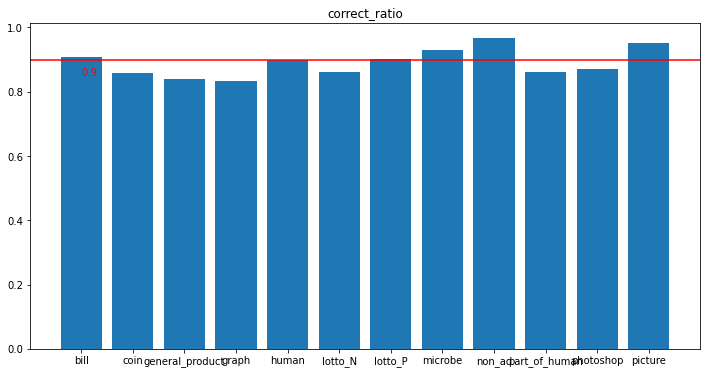

In [23]:
# 각 카테고리별 정확도(정답인 것의 수)
plt.figure(figsize=(12, 6))
plt.axhline(0.9, color='red')
plt.text(0.01, 0.85, '0.9', color='red')

plt.title('correct_ratio')
plt.bar(d.index, d['ratio'])

In [24]:
u = dataFrame.loc[dataFrame['y'] != dataFrame['pred']]

In [25]:
cnt = u['category'].value_counts()
print(cnt)

non_ad             11
graph               5
part_of_human       5
general_product     5
photoshop           5
lotto_N             4
human               4
coin                4
bill                3
lotto_P             3
picture             2
microbe             2
Name: category, dtype: int64


([<matplotlib.patches.Wedge at 0x23eb197de50>,
 [Text(0.874339879069462, 0.6674801688955252, 'non_ad'),
  Text(-0.03259668682645245, 1.0995169193822978, 'graph'),
  Text(-0.6412774562341247, 0.8937355448486373, 'part_of_human'),
  Text(-1.0311616431482036, 0.38302175617045153, 'general_product'),
  Text(-1.0692251924802005, -0.2583747041907896, 'photoshop'),
  Text(-0.7892579380820829, -0.7662061779798042, 'lotto_N'),
  Text(-0.3522967711379826, -1.0420590122664608, 'human'),
  Text(0.16241129920061914, -1.0879441942912178, 'coin'),
  Text(0.587205788881865, -0.9301555576910921, 'bill'),
  Text(0.8743399415634615, -0.667480087033915, 'lotto_P'),
  Text(1.0311616610787449, -0.38302170789829093, 'picture'),
  Text(1.0922792175659228, -0.1301003876765003, 'microbe')],
 [Text(0.47691266131061555, 0.3640800921248319, '20.75%'),
  Text(-0.01778001099624679, 0.5997365014812533, '9.43%'),
  Text(-0.3497877034004316, 0.4874921153719839, '9.43%'),
  Text(-0.5624518053535655, 0.20892095791115536,

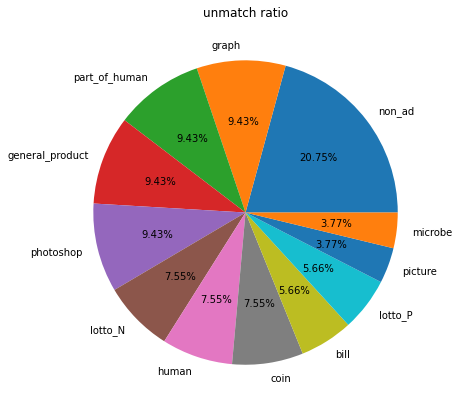

In [26]:
# 오답인 것들 중 각 카테고리의 비율
plt.figure(figsize=(7, 7))
plt.title('unmatch ratio')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%')

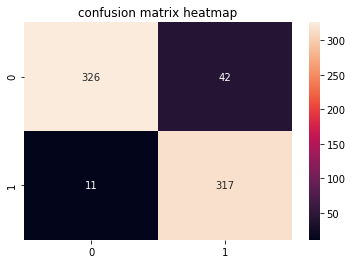

In [27]:
cm = confusion_matrix(y_original, prediction_original, labels=[0,1]) # 0: 광고, 1: 비광고

plt.title('confusion matrix heatmap')
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [28]:
dataFrame.to_csv('./binary_cnn_majority/csv/test_prediction_with_unmatch_iv40.csv') # 파일명 수정

------

In [31]:
cnt = dataFrame['category'].value_counts()

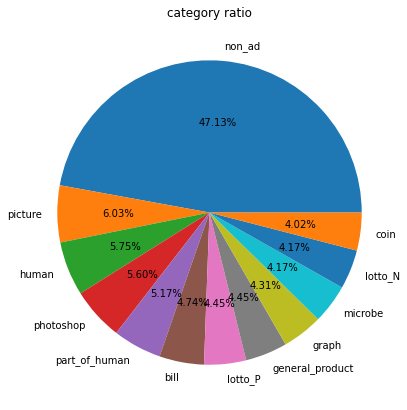

In [33]:
plt.figure(figsize=(7, 7))
plt.title('category ratio')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%')
plt.show()

In [44]:
index = [0.001, 0.005, 0.009, 0.015]
p_score = [0.9369, 0.9438, 0.9279, 1.0000]
r_score = [0.9055, 0.9207, 0.9024, 0.1402]
f1_score = [0.9209, 0.9321, 0.9150, 0.2459]

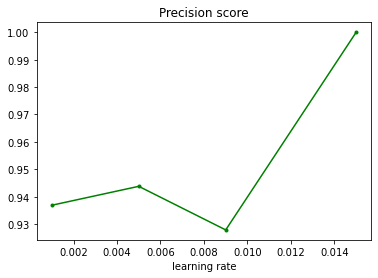

In [47]:
plt.title('Precision score')
plt.xlabel('learning rate')
plt.plot(index, p_score, 'g.-')

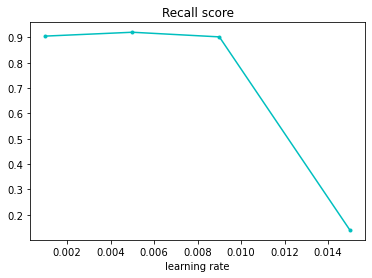

In [48]:
plt.title('Recall score')
plt.xlabel('learning rate')
plt.plot(index, r_score, 'c.-')

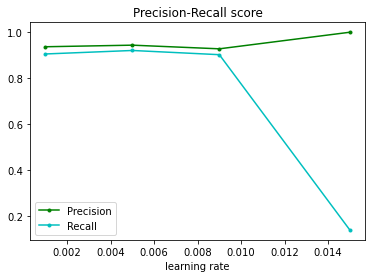

In [50]:
plt.title('Precision-Recall score')
plt.xlabel('learning rate')
plt.plot(index, p_score, 'g.-', label='Precision')
plt.plot(index, r_score, 'c.-', label='Recall')
plt.legend()

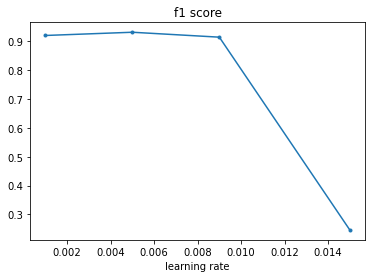

In [39]:
plt.title('f1 score')
plt.xlabel('learning rate')
plt.plot(index, f1_score, '.-')

In [51]:
index = [120, 160, 180, 200, 220, 240, 260, 280, 300, 320]
p_score = [0.8116, 0.8644, 1.0000, 1.0000, 0.9279, 0.8977, 1.0000, 0.8802, 0.9804, 0.5296]
r_score = [0.8933, 0.9329, 0.1921, 0.2470, 0.9024, 0.9360, 0.0549, 0.9634, 0.6098, 0.9817]

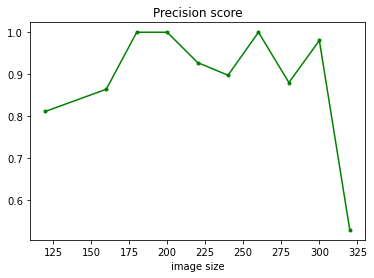

In [55]:
plt.title('Precision score')
plt.xlabel('image size')
plt.plot(index, p_score, 'g.-')

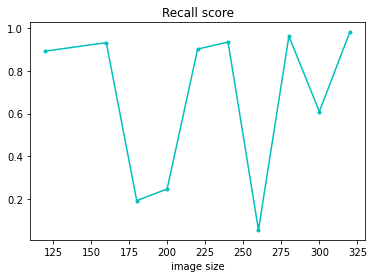

In [56]:
plt.title('Recall score')
plt.xlabel('image size')
plt.plot(index, r_score, 'c.-')

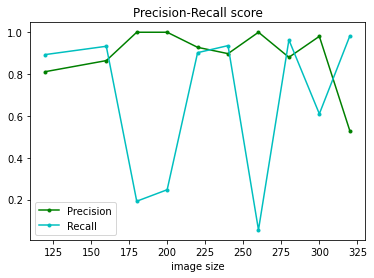

In [57]:
plt.title('Precision-Recall score')
plt.xlabel('image size')
plt.plot(index, p_score, 'g.-', label='Precision')
plt.plot(index, r_score, 'c.-', label='Recall')
plt.legend()

In [29]:
index = [0.1, 0.15, 0.2, 0.25]
p_score = [0.9735, 0.9438, 0.9554, 0.8889]
r_score = [0.7835, 0.9207, 0.9146, 0.9024]
f1_score = [0.8682, 0.9321, 0.9346, 0.8956]

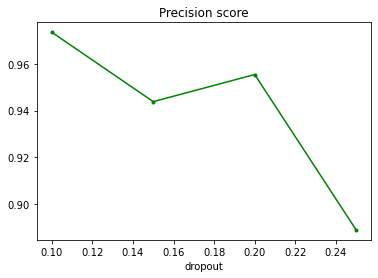

In [30]:
plt.title('Precision score')
plt.xlabel('dropout')
plt.plot(index, p_score, 'g.-')

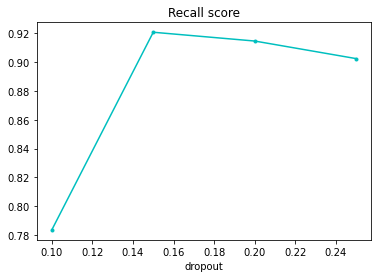

In [31]:
plt.title('Recall score')
plt.xlabel('dropout')
plt.plot(index, r_score, 'c.-')

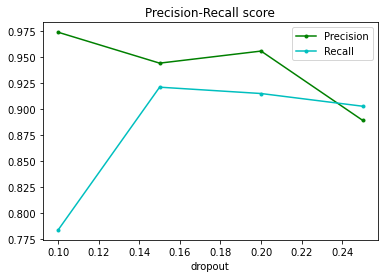

In [32]:
plt.title('Precision-Recall score')
plt.xlabel('dropout')
plt.plot(index, p_score, 'g.-', label='Precision')
plt.plot(index, r_score, 'c.-', label='Recall')
plt.legend()

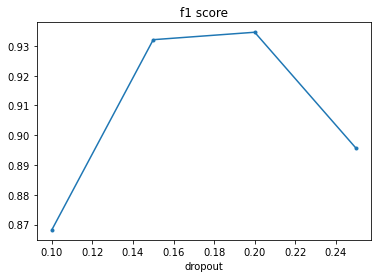

In [33]:
plt.title('f1 score')
plt.xlabel('dropout')
plt.plot(index, f1_score, '.-')

In [29]:
index = [40, 45, 50]
p_score = [0.9429, 0.9921, 0.8830]
r_score = [0.9055, 0.3841, 0.9665]
f1_score = [0.9238, 0.5538, 0.9229]

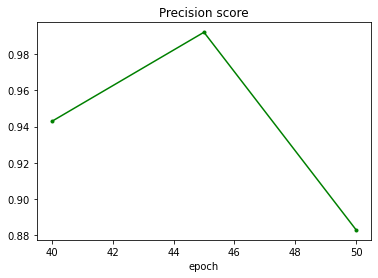

In [30]:
plt.title('Precision score')
plt.xlabel('epoch')
plt.plot(index, p_score, 'g.-')

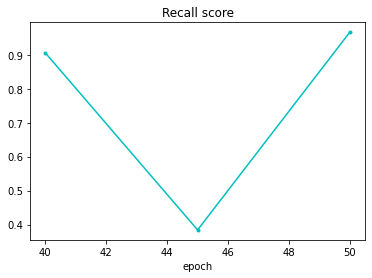

In [31]:
plt.title('Recall score')
plt.xlabel('epoch')
plt.plot(index, r_score, 'c.-')

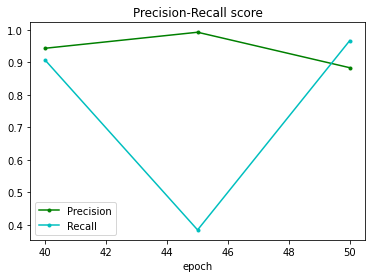

In [32]:
plt.title('Precision-Recall score')
plt.xlabel('epoch')
plt.plot(index, p_score, 'g.-', label='Precision')
plt.plot(index, r_score, 'c.-', label='Recall')
plt.legend()

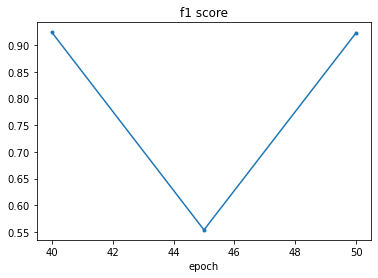

In [33]:
plt.title('f1 score')
plt.xlabel('epoch')
plt.plot(index, f1_score, '.-')